In [1]:
import functools
import itertools
import math
import re
import statistics
from functools import reduce
from pprint import pprint
from typing import (
    List,
    Optional,
    Generator,
    NamedTuple,
    Tuple,
    Set,
    Any,
    Dict,
    Union,
    Callable,
    Iterable,
    Sequence,
)

import rich.panel
import sklearn.base
from alive_progress import alive_bar
from numpy.distutils.misc_util import is_sequence
from tqdm import tqdm, trange
from log_symbols import LogSymbols

import overrides as overrides
import pandas as pds
import tabulate as tabulate
from collections import namedtuple
from sklearn import linear_model, metrics, preprocessing, model_selection, svm
from tabulate import tabulate
from pathlib import Path
import pickle
from halo import Halo
import random
import argparse
import sys
from sklearn.experimental import enable_halving_search_cv
from sklearn import neural_network, tree
from sklearn.model_selection import (
    HalvingGridSearchCV,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
import scipy.stats as scistats

import rich.progress
import commons
from data_types import PickleOut
from rich.traceback import install as niceTracebacks
from rich.table import Table as rTable

from db_actions import db_actions
import numpy as np

from linRegPred import getSplits, getTransformers
from scipy.stats import rankdata
from sklearn.metrics import r2_score
import textdistance as TD
import seaborn as sns

In [2]:
resultsPath = Path("../worksim/results")

In [3]:
cols = ["Workflow", "Distribution", "Error", "Scheduler", "Runtime"]
dF = pds.DataFrame(columns=cols)
for p in resultsPath.iterdir():
    dF = dF.append(pds.read_csv(p))[cols]

In [4]:
dF  #= dF.query("Scheduler != 'STATIC'")

,Workflow,Distribution,Error,Scheduler,Runtime
0,chipseq,normal,0.20,MINMIN,533.31
1,chipseq,normal,0.20,MAXMIN,353.21
2,chipseq,normal,0.20,MCT,354.55
3,chipseq,normal,0.20,ROUNDROBIN,561.69
4,chipseq,normal,0.20,STATIC,349.20
...,...,...,...,...,...
2595,chipseq,exponential,0.15,CRITICALPATHREVERSE,415.42
2596,chipseq,exponential,0.15,RESHIV2,401.30
2597,chipseq,exponential,0.15,RESHIV3,401.30
2598,chipseq,exponential,0.15,RESHIMAX,403.70


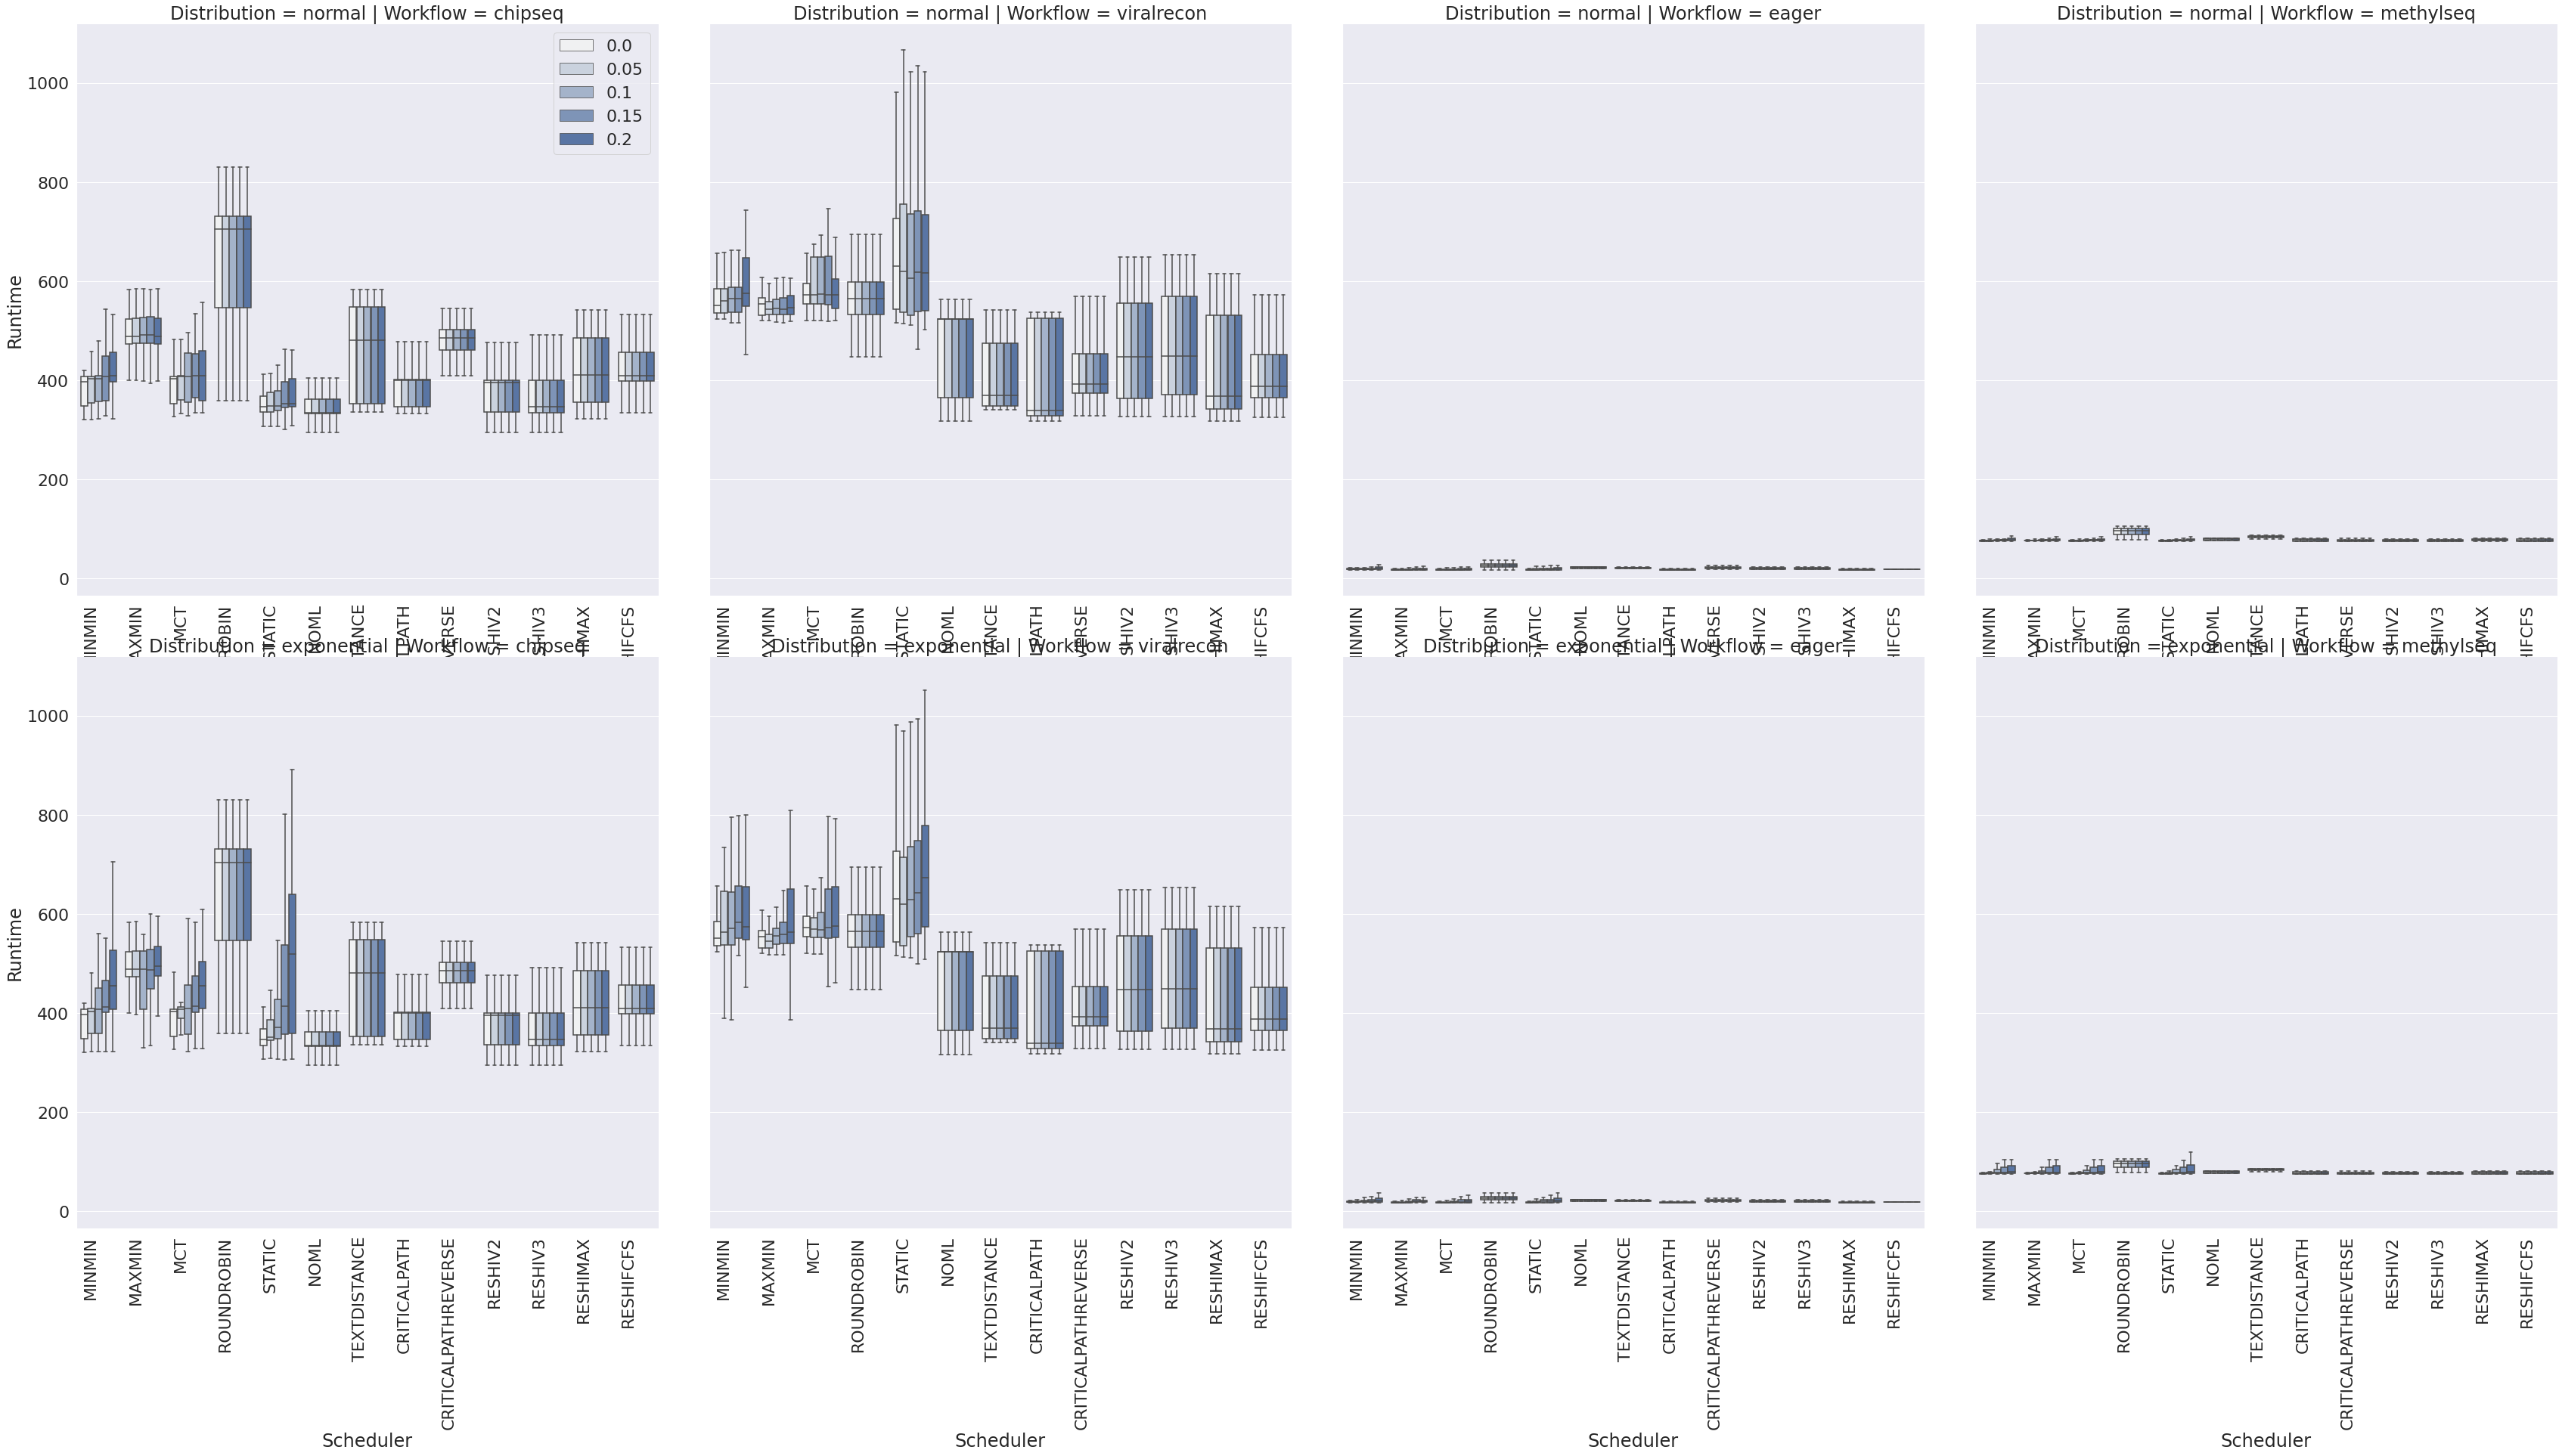

In [42]:
sns.set(font_scale=2)
g = sns.FacetGrid(dF, row="Distribution", col="Workflow", height=12, sharex=False, legend_out=False)
g.map_dataframe(sns.boxplot, x="Scheduler", y="Runtime", hue="Error", showfliers=False)
g.add_legend()
for p in g.axes.ravel():
    p.set_xticklabels(p.get_xticklabels(), rotation=90, horizontalalignment="right")

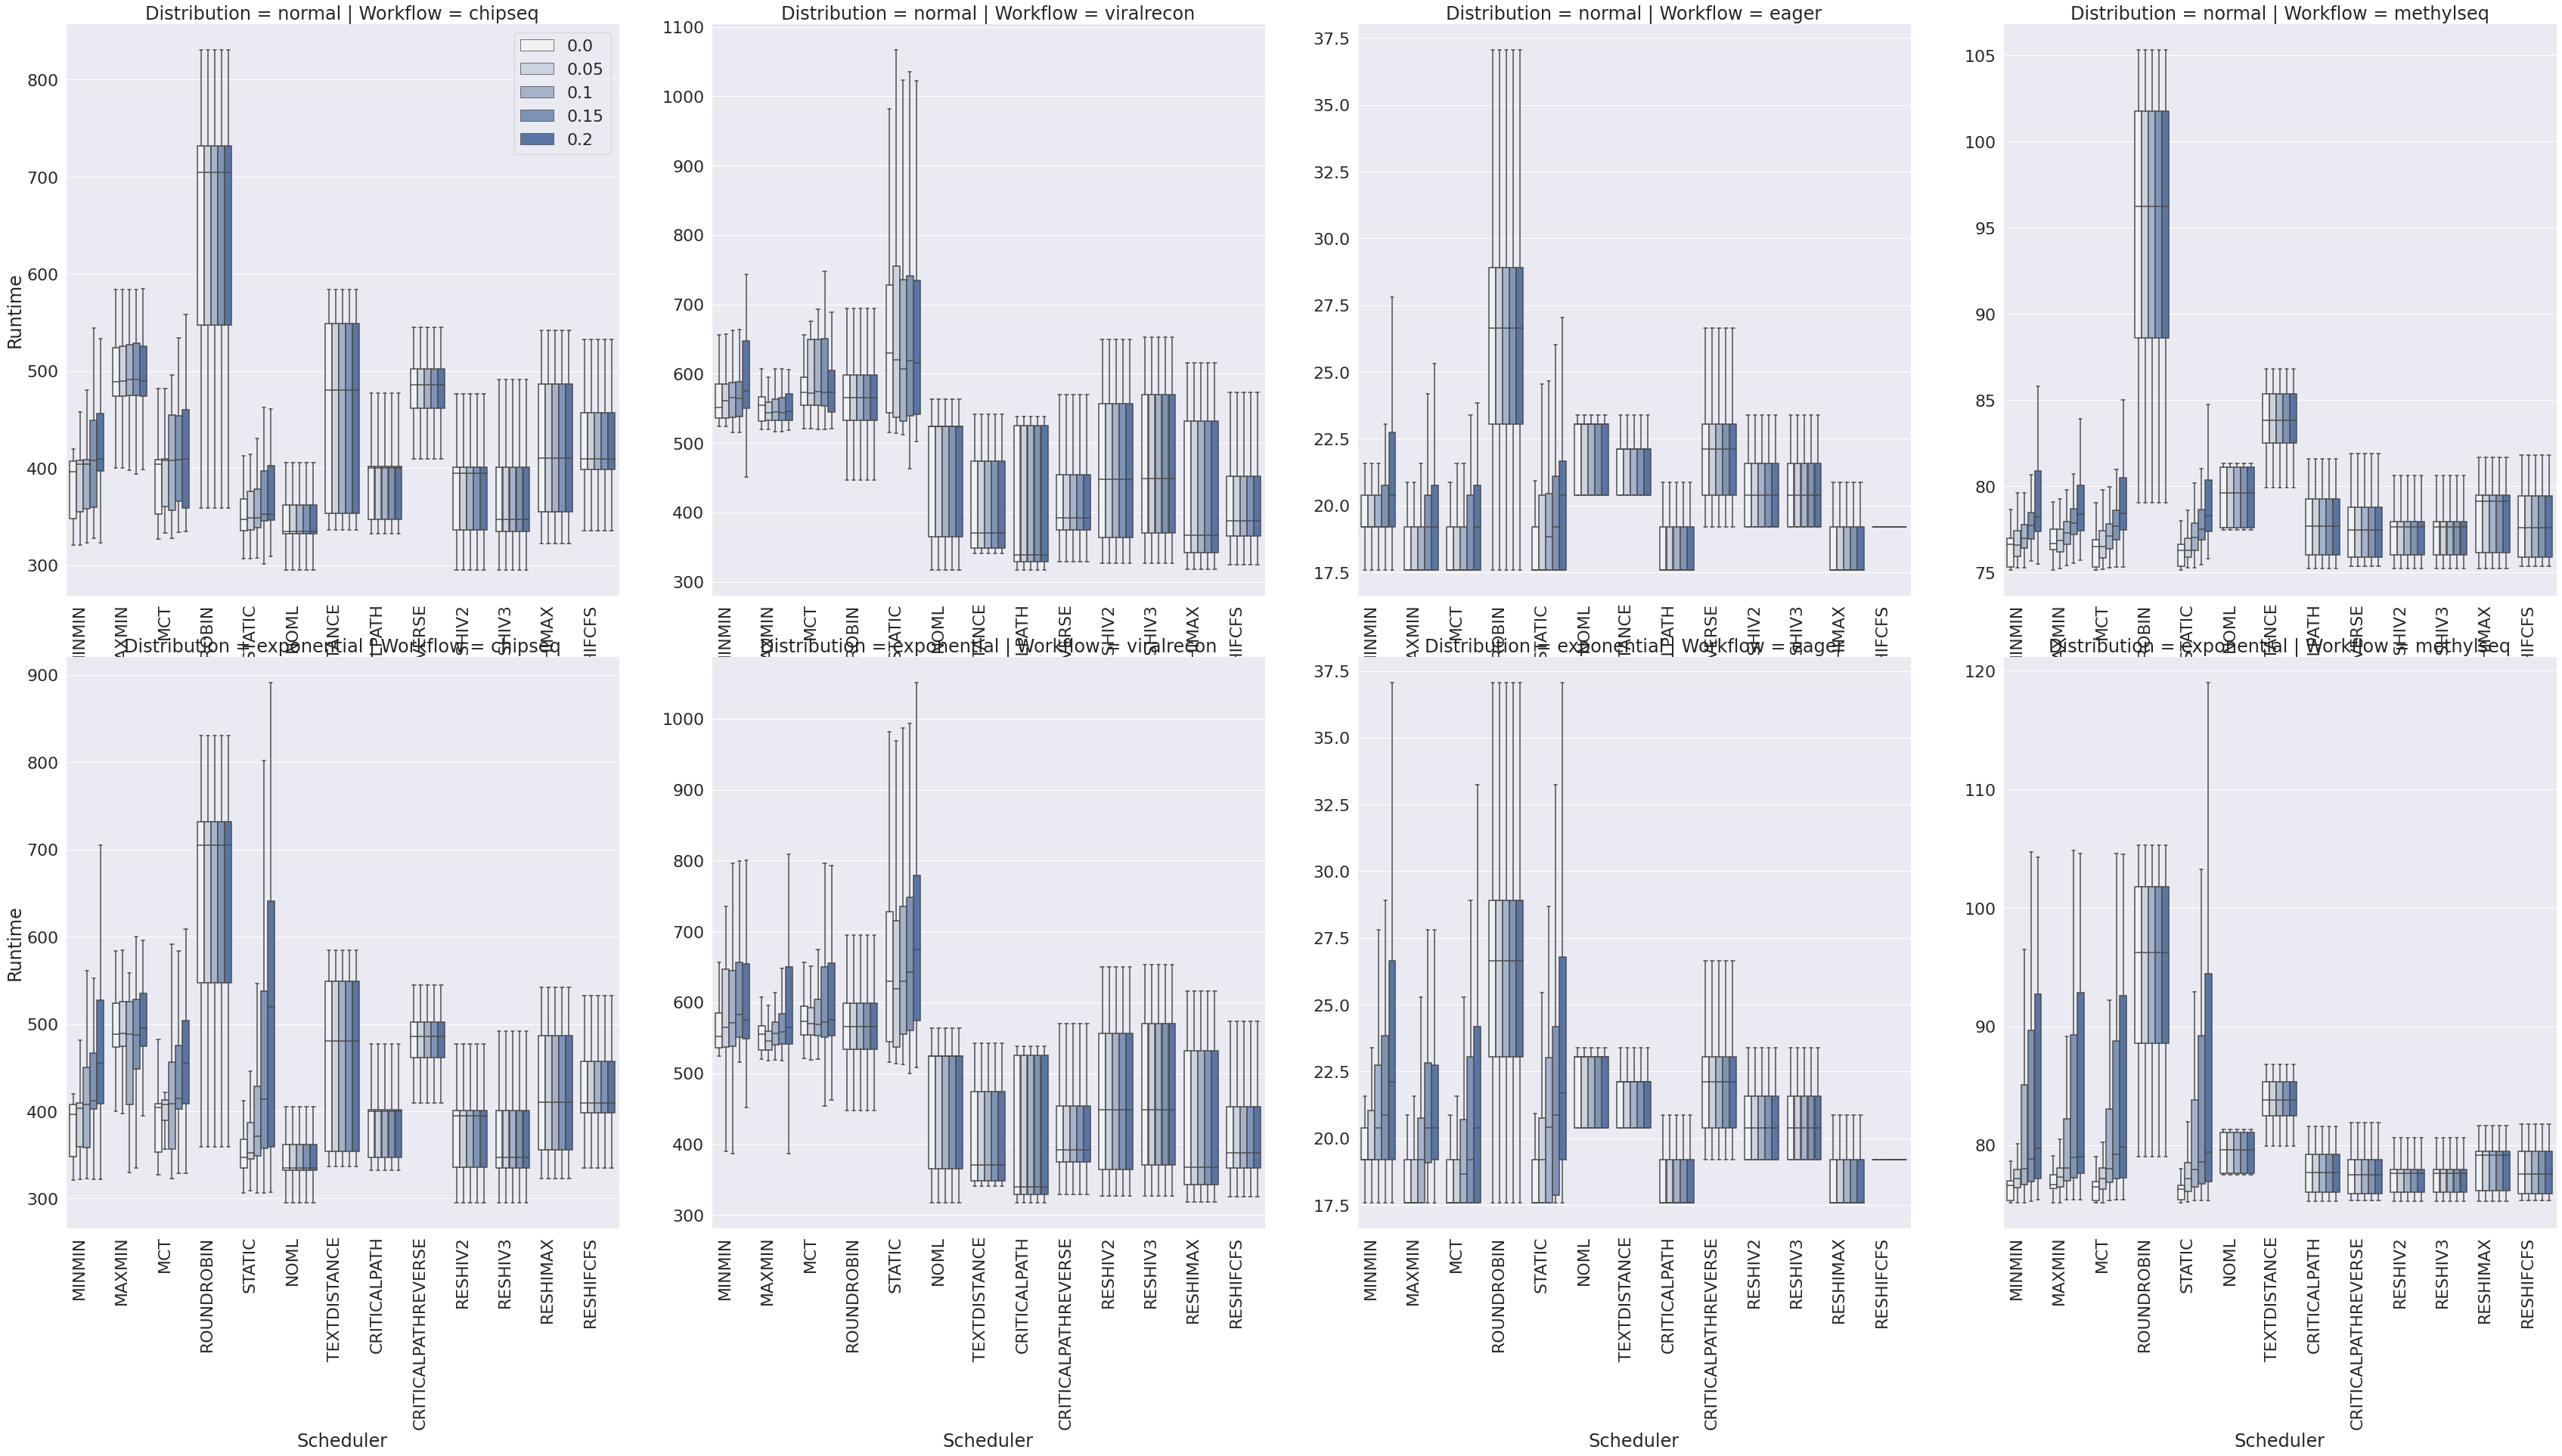

In [43]:
sns.set(font_scale=2)
g = sns.FacetGrid(dF, row="Distribution", col="Workflow", height=12, sharex=False, sharey=False, legend_out=False)
g.map_dataframe(sns.boxplot, x="Scheduler", y="Runtime", hue="Error", showfliers=False)
g.add_legend()
for p in g.axes.ravel():
    p.set_xticklabels(p.get_xticklabels(), rotation=90, horizontalalignment="right")

In [80]:
def rankingToGraphMatrix(ranking: np.ndarray):
    m = np.zeros(shape=(len(ranking), len(ranking)))
    for i, v in enumerate(ranking):
        for j, w in enumerate(ranking):
            m[i, j] = int(v < w)
    return m


def rankingDistance(ranking1: np.ndarray, ranking2: np.ndarray):
    return np.sum(np.sum(np.abs(rankingToGraphMatrix(ranking1) - rankingToGraphMatrix(ranking2))))


def rankingScore(ranking1: np.ndarray, ranking2: np.ndarray):
    return 1 - (rankingDistance(ranking1, ranking2) / len(ranking1) ** 2)

In [33]:
with db_actions.connect() as conn:
    dF = pds.read_sql('SELECT * FROM "runtimeScorePredBase1000"', conn)
# print(dF)
all_x_cols = [
    "build-linux-kernel1",
    "fio2",
    "fio3",
    "fio4",
    "fio5",
    "fio6",
    "fio7",
    "fio8",
    "fio9",
    "iperf10",
    "iperf11",
    "iperf12",
    "iperf13",
    "john-the-ripper14",
    "john-the-ripper15",
    "ramspeed16",
    "ramspeed17",
    "ramspeed18",
    "ramspeed19",
    "ramspeed20",
    "ramspeed21",
    "ramspeed22",
    "ramspeed23",
    "ramspeed24",
    "ramspeed25",
    "stream26",
    "stream27",
    "stream28",
    "stream29",
    "pCpu",
    "cpus",
    "rss",
    "vmem",
    "rchar",
    "wchar",
    "syscr",
    "syscw",
]
filtered_x_cols = ['john-the-ripper15', 'ramspeed17', 'ramspeed18', 'ramspeed19', 'ramspeed20', 'ramspeed21',
                   'ramspeed23', 'ramspeed24', 'ramspeed25', 'pCpu', 'cpus', 'vmem', 'rchar', 'wchar', 'syscr',
                   'syscw']
x_cols = all_x_cols
y_cols = "realtime"

In [44]:
comp_df = pds.DataFrame()
for p in Path("../worksim/src/main/resources/config/ranking").iterdir():
    if re.compile(r"Decision Tree").search(p.name) is not None:
        comp_df = comp_df.append(pds.read_csv(p))

In [46]:
comp_df

,wfName,taskName,nodeName,rank
0,nfcore/eager:2.3.5,damageprofiler,m5zn.large,1.0
1,nfcore/eager:2.3.5,damageprofiler,m5zn.xlarge,2.0
2,nfcore/eager:2.3.5,damageprofiler,m5zn.2xlarge,3.0
3,nfcore/eager:2.3.5,damageprofiler,z1d.large,4.0
4,nfcore/eager:2.3.5,damageprofiler,z1d.xlarge,5.0
...,...,...,...,...
535,nfcore/chipseq:1.2.2,TRIMGALORE,r5a.large,23.0
536,nfcore/chipseq:1.2.2,TRIMGALORE,r5a.xlarge,24.0
537,nfcore/chipseq:1.2.2,TRIMGALORE,m5a.xlarge,25.0
538,nfcore/chipseq:1.2.2,TRIMGALORE,m5a.2xlarge,26.0


In [48]:
from my_yaml import yaml_load

with open("nodeConfigIdLookup.yaml", "r") as f:
    t = yaml_load(f)
    nodeIDLUT = {v: k for k, v in t.items()}
dF["nodeName"] = dF["nodeConfig"].transform(lambda x: nodeIDLUT[x])

In [65]:
true_df = pds.DataFrame()
for l, d in dF.groupby(by=["wfName", "taskName", "nodeName"]):
    wn, tn, nn = l
    true_df = true_df.append({"wfName": wn, "taskName": tn, "nodeName": nn, "realtime": d.realtime.mean(), "rank": 0},
                             ignore_index=True)

for l, d in true_df.groupby(by=["wfName", "taskName"]):
    wn, tn = l
    ranks = rankdata(d.realtime.values, method="min")
    d["rank"] = ranks
    true_df.update(d)

In [69]:
true_df

,wfName,taskName,nodeName,realtime,rank
0,nfcore/chipseq:1.2.2,BWA_INDEX,c5.2xlarge,6490.400000,4.0
1,nfcore/chipseq:1.2.2,BWA_INDEX,c5.xlarge,9775.400000,20.0
2,nfcore/chipseq:1.2.2,BWA_INDEX,c5a.2xlarge,6593.200000,5.0
3,nfcore/chipseq:1.2.2,BWA_INDEX,c5a.xlarge,5716.400000,2.0
4,nfcore/chipseq:1.2.2,BWA_INDEX,d3.2xlarge,9294.200000,19.0
...,...,...,...,...,...
2128,nfcore/viralrecon:2.1,NFCORE_VIRALRECON:ILLUMINA:VARIANTS_IVAR:SNPEF...,r5a.large,3933.333333,23.0
2129,nfcore/viralrecon:2.1,NFCORE_VIRALRECON:ILLUMINA:VARIANTS_IVAR:SNPEF...,r5a.xlarge,3800.000000,19.0
2130,nfcore/viralrecon:2.1,NFCORE_VIRALRECON:ILLUMINA:VARIANTS_IVAR:SNPEF...,z1d.2xlarge,3000.000000,3.0
2131,nfcore/viralrecon:2.1,NFCORE_VIRALRECON:ILLUMINA:VARIANTS_IVAR:SNPEF...,z1d.large,3133.333333,9.0


In [73]:
comp_comp_df = true_df.join(comp_df.set_index(["wfName", "taskName", "nodeName"]),
                            on=["wfName", "taskName", "nodeName"], rsuffix="_comp")

In [81]:
scores = list()
for l, d in comp_comp_df.groupby(by=["wfName", "taskName"]):
    scores.append(rankingScore(d["rank"], d["rank_comp"]))

In [85]:
print(np.average(scores), np.std(scores))

0.979146047125419 0.062485781178675585
